# How to get weighted and unweighted estimates in Python
## Using [2022 data](https://www.census.gov/programs-surveys/nsch/data/datasets.2022.html) from the [National Survey of Children's Health](https://www.childhealthdata.org/learn-about-the-nsch/NSCH)
## PHYSACTIV = Physical Activity Ages 6-11

### Jupyter Notebook Notes
For anyone new to notebooks, each cell should have only a single print. If you put in two, you'll only see the last one.

### Set Up - pip install and import

In [1]:
### If you don't already have the following packages, install them.
# !pip install pyreadstat
# !pip install pandas
# !pip install sidecar
# !pip install gzip
# !pip install zipfile
# !pip install numpy
# !pip install matplotlib
## if the above don't work, try this on your command line or terminal:
# pip install PACKAGE
#      for example, pip install matplotlib
## if that doesn't work, you can try this on your command line or terminal:
# python -m pip install PACKAGE
#      for example, python -m pip install matplotlib

In [3]:
import pyreadstat #reads SAS files quickly and they take up less memory
import os #file paths
import pandas as pd
import pickle #to save the SAS data files for python to read again
import gzip #to zip the object
import zipfile
import numpy as np #weighted mean and std
import math #used with numpy
from sidecar import Sidecar
import matplotlib.pyplot as plt

### With import os, we use strings to represent files and directories

In [2]:
#set some paths, files, and a variable
my_dir = "C:/nsch"

# sas file paths
screener_data = os.path.join(my_dir, "nsch_2022e_screener.sas7bdat")
topic_data = os.path.join(my_dir, "nsch_2022e_topical.sas7bdat")

#working on *nix? change to 'gz'
zipext='zip'

### pickle to read and write - .zip extension will 
###   signal pandas to compress it for you
screener_pkl = os.path.join(my_dir, "nsch_2022e_screener."+zipext)
meta_screener_pkl = os.path.join(my_dir, "nsch_2022e_screener_meta.pkl")
meta_screener_zip = os.path.join(my_dir, "nsch_2022e_screener_meta."+zipext)

topic_pkl = os.path.join(my_dir, "nsch_2022e_topical."+zipext)
meta_topic_pkl = os.path.join(my_dir, "nsch_2022e_topic_meta.pkl")
meta_topic_zip = os.path.join(my_dir, "nsch_2022e_topic_meta."+zipext)

### Variables

In [3]:
file_enc = 'cp1252' 
#this was added after the fact, 
#I imported the data with pyreadstat, and used the metadata object to tell me what the file encoding is

### Utility functions

In [4]:
def format_numbers(x):
    return f"{x:,.0f}"

# Read in data
## The first time, we'll save to disk.
## SAS data (sas7bdat) to dataframe to pickle.
We can read this back in using python, keep the data compressed on disk. It will be smaller than the SAS data.

### SAS file encoding
Sometimes you can get the SAS encoding from the data source. They'll tell you.\
If you have SAS, you can use it to tell you.\
I ran the below to have the metadata object tell me what the encoding is.\
It said file_encoding is WINDOWS-1252. A google search says that encoding is equivalent to CP-1252, which is\
  an option available in pyreadstat

In [5]:
df_screener, meta_screener = pyreadstat.read_sas7bdat(screener_data)
df_topic, meta_topic = pyreadstat.read_sas7bdat(topic_data)
meta_screener.file_encoding
meta_topic.file_encoding

pyreadstat uses a C library under the hood - much faster than\ 
   using pandas to import SAS. Plus, you can get the SAS metadata,\
   and it's able to import large datasets into memory that pandas can't.\
   You need to specify encoding for it to properly import strings.\
   If you don't, you'll see the strings wrapped in b''

pyreadstat outputs a SAS dataset (df_screener and df_topic are sas datasets) and a metadata object\
the metadata object isn't a dataframe

In [6]:
df_screener, meta_screener = pyreadstat.read_sas7bdat(screener_data, encoding=file_enc)
df_topic, meta_topic = pyreadstat.read_sas7bdat(topic_data, encoding=file_enc)

The following method will allow us to save (serialize) the metadata object to disk.

In [7]:
@staticmethod
def zip_pkl(obj, pkl, zip):
    #object to pickle
    with open(pkl, 'wb') as f:
        pickle.dump(obj, f)

    #pickle to zip
    with zipfile.ZipFile(zip, 'w') as z:
        z.write(pkl)

Serialize dataframes and objects to disk. We are pickling them.

In [8]:
df_screener.to_pickle(screener_pkl, compression=zipext)

zip_pkl(meta_screener, meta_screener_pkl, meta_screener_zip)

df_topic.to_pickle(topic_pkl, compression=zipext)

zip_pkl(meta_topic, meta_topic_pkl, meta_topic_zip)

# Read in data 
## after saving to disk

In [9]:
# df_screener = pd.read_pickle(screener_pkl, compression=zipext)
# df_topic = pd.read_pickle(topic_pkl, compression=zipext)

|Extension|Screener Size|Topic Size|
|:-|:-:|:-:|
|sas7bdat|37mb|207mb|
|compressed sas7bdat|3.9mb|16.6mb|
|compressed pickle|1.8mb|7.6mb|
|compressed metadata|0.004mb|0.005mb|

### Exploratory Analysis

In [10]:
#I like to see the data in a table
sc1 = Sidecar(title='Screener')
with sc1:
    display(df_screener)

sc2 = Sidecar(title='Topic')
with sc2:
    display(df_topic)

#### Survey weight is FWC
#### Physical activity
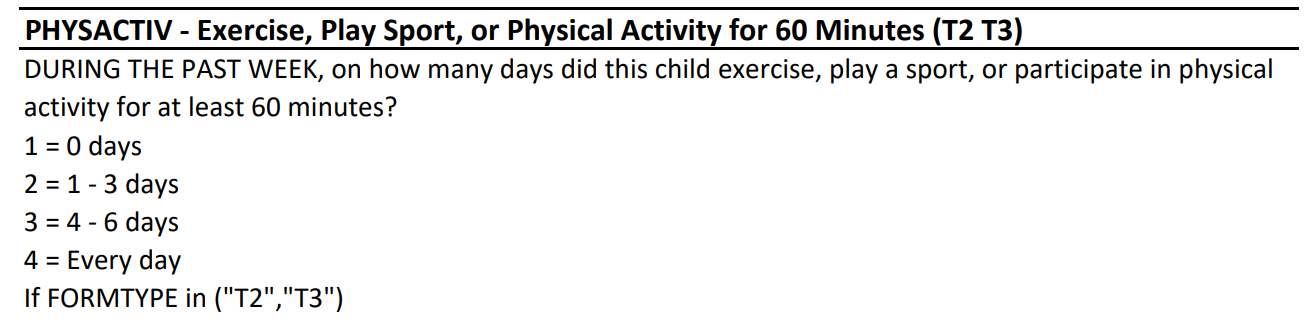

In [33]:
physactiv_dict = {1:"1) 0 days", 2:"2) 1-3 days", 3:"3) 4-6 days", 4:"4) everyday"}
physactiv_label = ["1) 0 days", "2) 1-3 days", "3) 4-6 days", "4) everyday"]

In [34]:
### https://www.childhealthdata.org/browse/survey/results?q=10012&r=1
### childhealthdata.org has a tool to look at weighted estimates
### This survey question asked, “During the past week, on how many days did this child exercise, play a sport, or participate in physical activity for at least 60 minutes?”
#physactiv_unwgt are the unweighted counts
#Numerator: 0 days; 1-3 days; 4-6 days; Everyday
    
physactiv_unwgt = df_topic['PHYSACTIV'].value_counts().rename(index=physactiv_dict).sort_index()
physactiv_unwgt.apply(format_numbers)

PHYSACTIV
1) 0 days       3,367
2) 1-3 days    13,619
3) 4-6 days    10,312
4) everyday     6,609
Name: count, dtype: object

In [35]:
age_subset = df_topic[(df_topic['SC_AGE_YEARS'] >= 6.0) & (df_topic['SC_AGE_YEARS'] <= 11.0)]
physactiv_6_11_unwgt = age_subset['PHYSACTIV'].value_counts().rename(index=physactiv_dict).sort_index()
physactiv_6_11_unwgt.apply(format_numbers)

PHYSACTIV
1) 0 days        737
2) 1-3 days    5,808
3) 4-6 days    4,621
4) everyday    3,985
Name: count, dtype: object

From the website - great, we match!:\
1: 0 days = (737) 1,538,118\
2: 1-3 days = (5808) 9,842,742\
3: 4-6 days = (4621) 6,643,383\
4: everyday = (3985) 6,088,124\
sum = 24,112,367 children ages 6-11 who answered this question\
estimated number of children ages 6-11 = 24,482,676

In [36]:
#a different way of seeing the values
physactiv_6_11_unwgt.values

array([ 737, 5808, 4621, 3985], dtype=int64)

In [37]:
#series with 1-4 label
weight_6_11 = age_subset['FWC'].groupby(age_subset['PHYSACTIV']).sum()
weight_6_11

PHYSACTIV
1.0    1.538118e+06
2.0    9.842742e+06
3.0    6.643383e+06
4.0    6.088124e+06
Name: FWC, dtype: float64

In [38]:
## list of numbers formatted with commas so you can see it 
##    with readable formatted numbers
physactiv_6_11_wgt = [f'{round(x):,}' for x in weight_6_11]    

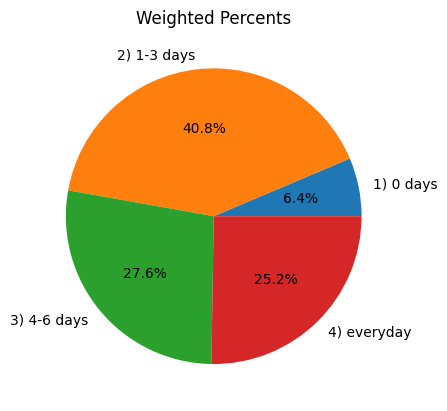

In [41]:
#pie chart of weight_6_11 series, which still has series labels
#notice the percents that the plot creates match the percents from the survey's website
fig, ax = plt.subplots()
ax.pie(weight_6_11, labels=physactiv_label, autopct="%1.1f%%")
ax.set_title("Weighted Percents")
plt.show()

In [42]:
#dataframe mean gives 2.78
round(age_subset['PHYSACTIV'].mean(),2) #pandas drops NA by default

2.78

In [43]:
#numpy mean gives the same result
round(np.mean(age_subset['PHYSACTIV']),2)

2.78

In [44]:
#from stackoverflow
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (round(average,2), round(math.sqrt(variance),2))
weighted_avg_and_std(age_subset['PHYSACTIV'].value_counts().index, age_subset['FWC'].groupby(age_subset['PHYSACTIV']).sum())

(2.71, 1.12)

In [ ]:
#weighted_estimate(df_topic['PHYSACTIV'], df_topic['FWC'], physactiv_unwgt)
#(age_subset['PHYSACTIV']*age_subset['FWC']).sum() = 65,506,242.52
#jupyter will only display one line of print per cell, so combine these into one line:
children_6_11 = age_subset['FWC'].sum()
#24,482,676.13
"number of children ages 6-11",f'{children_6_11:,.2f}'

# Checks
There are estimates above that are mentioned as checks to show that estimates match the source. These are the types of checks you want to do with data. 
* Are your findings similar to what's out there?
* If you're learning how to use a new survey, check that your basic counts and weighted estimates match the source. That's how you know you've configured things properly.

# From Census
## Current Population Survey
https://www.census.gov/data/tables/2022/demo/age-and-sex/2022-age-sex-composition.html
Census breaks up the age differently on their website\
Census reports 20.228 million children ages 5-9 in 2022

https://www.childstats.gov/AMERICASCHILDREN/tables/pop1.asp
Census Current Population Survey, Childstats.org\
reports 24.2 million children ages 6-11 in 2022


# From childhealthdata.org
https://www.childhealthdata.org/browse/survey/results?q=10012&r=1
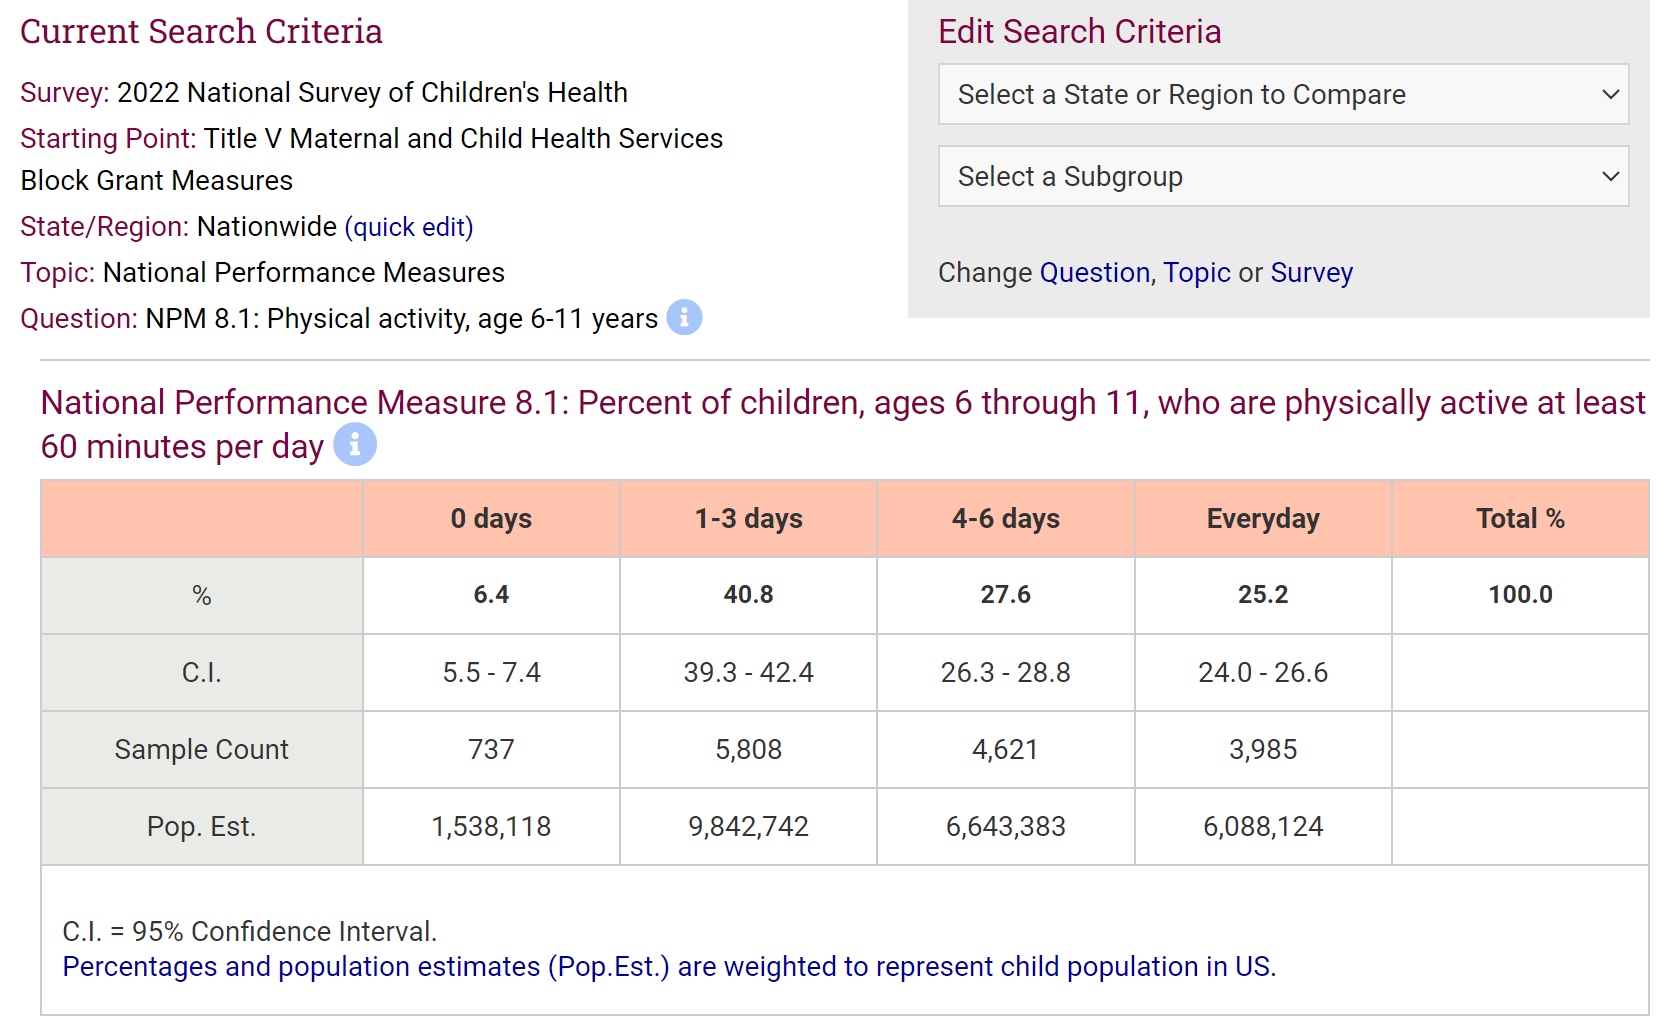